In [1]:
import tensorflow as tf
import numpy as np
from censai.models import CosmosAutoencoder as Autoencoder
from censai.data.cosmos import decode, preprocess
from censai.utils import nullwriter
import os
from datetime import datetime
from argparse import ArgumentParser
from censai.galflow import convolve
from scipy.signal import tukey
from numpy import pi
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import time
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#     # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#         print(e)


class PolynomialSchedule:
    def __init__(self, initial_value, end_value, power, decay_steps):
        self.initial_value = initial_value
        self.end_value = end_value
        self.power = power
        self.decay_steps = decay_steps

    def __call__(self, step=None):
        if step is None:
            step = tf.summary.experimental.get_step()
        step = min(step, self.decay_steps)
        return ((self.initial_value - self.end_value) * (1 - step / self.decay_steps) ** (self.power)) + self.end_value


def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    '''
    return [atoi(c) for c in re.split(r'(\d+)', text)]


In [ ]:
import tensorflow as tf
from censai.models.layers.resnet_block import ResidualBlock
from numpy import pi
from censai.galflow import convolve
from scipy.signal.windows import tukey
import numpy as np


class Encoder(tf.keras.Model):
    def __init__(
            self,
            res_layers=7,
            conv_layers_in_resblock=2,
            filter_scaling=2,
            filter_init=8,
            kernel_size=3,
            res_architecture="bare",
            kernel_reg_amp=0.01,
            bias_reg_amp=0.01,
            alpha=0.04,
            resblock_dropout_rate=None,
            kernel_initializer="he_uniform",
            mlp_bottleneck_neurons=16,
            **kwargs
    ):
        super(Encoder, self).__init__()
        self._num_layers = res_layers
        self.res_blocks = []
        self.downsample_conv = []
        self.mlp_bottleneck = tf.keras.layers.Dense(
            units=mlp_bottleneck_neurons,
            kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)
        )
        for i in range(res_layers):
            self.downsample_conv.append(
                tf.keras.layers.Conv2D(
                    filters=filter_init * int(filter_scaling ** i),
                    kernel_size=kernel_size,
                    strides=2,
                    padding="same",
                    data_format="channels_last",
                    kernel_initializer=kernel_initializer,
                    activation=tf.keras.layers.LeakyReLU(alpha),
                    kernel_regularizer=tf.keras.regularizers.l2(kernel_reg_amp),
                    bias_regularizer=tf.keras.regularizers.l2(bias_reg_amp),
                )
            )
            self.res_blocks.append(
                ResidualBlock(
                    filters=filter_init * int(filter_scaling ** i),
                    kernel_size=kernel_size,
                    conv_layers=conv_layers_in_resblock,
                    bias_reg_amp=bias_reg_amp,
                    kernel_reg_amp=kernel_reg_amp,
                    alpha=alpha,
                    dropout_rate=resblock_dropout_rate,
                    architecture=res_architecture,
                    **kwargs
                )
            )
        self.flatten = tf.keras.layers.Flatten(data_format="channels_last")

    def __call__(self, x):
        return self.call(x)

    def call(self, x):
        for i in range(self._num_layers):
            x = self.downsample_conv[i](x)
            x = self.res_blocks[i](x)
        x = tf.keras.layers.Flatten(data_format="channels_last")(x)
        x = self.mlp_bottleneck(x)
        return x

    def call_with_skip_connections(self, x):
        """ Use in training autoencoder """
        skips = []
        for i in range(self._num_layers):
            x = self.downsample_conv[i](x)
            x = self.res_blocks[i](x)
            skips.append(tf.identity(x))
        x = self.flatten(x)
        skips.append(tf.identity(x))  # recorded for l2 loss of bottleneck. In reality, its just a reshaped copy of previous skip
        x = self.mlp_bottleneck(x)
        return x, skips[::-1]


class Decoder(tf.keras.Model):
    def __init__(
            self,
            mlp_bottleneck,  # should match flattened dimension before mlp in encoder
            z_reshape_pix,   # should match dimension of encoder layer pre-mlp
            res_layers=7,
            conv_layers_in_resblock=2,
            filter_scaling=2,
            filter_init=8,
            kernel_size=3,
            res_architecture="bare",
            kernel_reg_amp=0.01,
            bias_reg_amp=0.01,
            alpha=0.04,
            resblock_dropout_rate=None,
            kernel_initializer="he_uniform",
            **kwargs
    ):
        super(Decoder, self).__init__()
        self._z_pix = z_reshape_pix
        self._z_filters = filter_init*(int(filter_scaling**(res_layers-1)))
        self._num_layers = res_layers
        self.res_blocks = []
        self.upsample_conv = []
        for i in reversed(range(res_layers)):
            self.upsample_conv.append(
                tf.keras.layers.Conv2DTranspose(
                    filters=(filter_init * max(1, int(filter_scaling ** (i - 1)))) ** (0 if i==0 else 1),
                    kernel_size=kernel_size,
                    strides=2,
                    padding="same",
                    data_format="channels_last",
                    kernel_initializer=kernel_initializer,
                    activation=tf.keras.layers.LeakyReLU(alpha),
                    kernel_regularizer=tf.keras.regularizers.l2(kernel_reg_amp),
                    bias_regularizer=tf.keras.regularizers.l2(bias_reg_amp),
                )
            )
            self.res_blocks.append(
                ResidualBlock(
                    filters=(filter_init * max(1, int(filter_scaling ** (i - 1)))) ** (0 if i==0 else 1),
                    kernel_size=kernel_size,
                    conv_layers=conv_layers_in_resblock,
                    bias_reg_amp=bias_reg_amp,
                    kernel_reg_amp=kernel_reg_amp,
                    alpha=alpha,
                    dropout_rate=resblock_dropout_rate,
                    architecture=res_architecture,
                    **kwargs
                )
            )
        self.mlp_bottleneck = tf.keras.layers.Dense(
            units=mlp_bottleneck,
            kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)
        )
        self.output_layer = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=3,
            padding="SAME",
            activation=tf.keras.activations.softplus,  # ensures output positivity
            kernel_initializer=kernel_initializer,
        )

    def __call__(self, z):
        return self.call(z)

    def call(self, z):
        z = self.mlp_bottleneck(z)
        batch_size, _ = z.shape
        x = tf.reshape(z, [batch_size, self._z_pix, self._z_pix, self._z_filters])
        for i in range(self._num_layers):
            x = self.upsample_conv[i](x)
            x = self.res_blocks[i](x)
        x = self.output_layer(x)
        return x

    def call_with_skip_connections(self, z, skips: list, skip_strength, l2):
        z = self.mlp_bottleneck(z)
        # add l2 cost for latent representation (we want identity map between this stage and pre-mlp stage of encoder)
        bottleneck_l2_cost = l2 * tf.reduce_mean((z - skips[0])**2, axis=1)
        batch_size, _ = z.shape
        x = tf.reshape(z, [batch_size, self._z_pix, self._z_pix, self._z_filters])
        for i in range(self._num_layers):
            x = tf.add(x, skip_strength * skips[i+1])
            x = self.upsample_conv[i](x)
            x = self.res_blocks[i](x)
        x = self.output_layer(x)
        return x, bottleneck_l2_cost


class CosmosAutoencoder(tf.keras.Model):
    def __init__(
            self,
            pixels=128,  # side length of the input image, used to compute shape of bottleneck mainly
            res_layers=7,
            conv_layers_in_resblock=2,
            filter_scaling=2,
            filter_init=8,
            kernel_size=3,
            res_architecture="bare",
            kernel_reg_amp=0.01,
            bias_reg_amp=0.01,
            alpha=0.04,
            resblock_dropout_rate=None,
            kernel_initializer="he_uniform",
            latent_size=16,
            image_floor=1e-8,
            **kwargs
    ):
        super(CosmosAutoencoder, self).__init__()
        self.image_floor = image_floor
        self.encoder = Encoder(
            res_layers=res_layers,
            conv_layers_in_resblock=conv_layers_in_resblock,
            filter_scaling=filter_scaling,
            filter_init=filter_init,
            kernel_size=kernel_size,
            res_architecture=res_architecture,
            kernel_reg_amp=kernel_reg_amp,
            bias_reg_amp=bias_reg_amp,
            alpha=alpha,
            resblock_dropout_rate=resblock_dropout_rate,
            kernel_initializer=kernel_initializer,
            mlp_bottleneck_neurons=latent_size,
            **kwargs
        )
        # compute size of mlp bottleneck from size of image and # of filters in the last encoding layer
        filters = filter_init*(int(filter_scaling**(res_layers-1)))
        pix = pixels//2**(res_layers)
        mlp_bottleneck = filters * pix**2
        self.decoder = Decoder(
            mlp_bottleneck=mlp_bottleneck,
            z_reshape_pix=pix,
            res_layers=res_layers,
            conv_layers_in_resblock=conv_layers_in_resblock,
            filter_scaling=filter_scaling,
            filter_init=filter_init,
            kernel_size=kernel_size,
            res_architecture=res_architecture,
            kernel_reg_amp=kernel_reg_amp,
            bias_reg_amp=bias_reg_amp,
            alpha=alpha,
            resblock_dropout_rate=resblock_dropout_rate,
            kernel_initializer=kernel_initializer,
            **kwargs
        )

    def encode(self, x, psf):
        """

        Args:
            x: Batch of image of shape [None, pixels, pixels, 1]
            psf: Batch of the real FT of PSF associated with images, with noise padding, shape [None, 2*pixels, pixels+1, 1]

        Returns: Encoder latent vector z (shape [None, num_latent_variables])

        """
        input_shape = x.shape
        psf_image = tf.signal.irfft2d(tf.cast(psf[..., 0], tf.complex64))[..., tf.newaxis]
        # Roll the image to undo the fftshift, assuming x1 zero padding and x2 subsampling
        psf_image = tf.roll(psf_image, shift=[input_shape[1], input_shape[2]], axis=[1, 2])
        psf_image = tf.image.resize_with_crop_or_pad(psf_image, input_shape[1], input_shape[2])
        x = tf.concat([x, psf_image], axis=-1)
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def __call__(self, x, psf):
        return self.call(x, psf)

    def call(self, x, psf_image):
        x = tf.concat([x, psf_image], axis=-1)
        return self.decoder(self.encoder(x))

    def cost_function(self, x, psf, ps):
        """

        Args:
            x: Batch of image of shape [None, pixels, pixels, 1]
            psf: Batch of the real FT of PSF associated with images, with noise padding, shape [None, 2*pixels, pixels+1, 1]
            ps: Power spectrum of the noise, shape [None, pixels, pixels//2+1, 1], encoded as log(ps**2)

        Returns: Chi squared and added regularizer (except weight regularizers) -> scalar for each example

        """
        x_pred = self.decode(self.encode(x, psf))
        x_pred = convolve(x_pred, tf.cast(psf[..., 0], tf.complex64), zero_padding_factor=1)

        x = tf.signal.rfft2d(x[..., 0])
        x_pred = tf.signal.rfft2d(x_pred[..., 0])

        chi_squared = 0.5 * tf.reduce_mean(tf.abs((x - x_pred)**2 / tf.complex(tf.exp(ps) + 1e-8, 0.) / (2 * pi) ** 2), axis=[1, 2])
        return chi_squared

    def training_cost_function(self, image, psf, ps, skip_strength, l2_bottleneck, apodization_alpha, apodization_factor, tv_factor):
        """

        Args:
            x: Batch of image of shape [None, pixels, pixels, 1]
            psf: Batch of the real FT of PSF associated with images, with noise padding, shape [None, 2*pixels, pixels+1, 1]
            ps: Power spectrum of the noise, shape [None, pixels, pixels//2+1, 1], encoded as log(ps**2)
            skip_strength: Multiplicative factor applied to skip connections between encoder and decoder
            l2_bottleneck: l2 factor applied on identity loss in bottleneck
            apodization_alpha: Shape parameter of the Tukey window (Tapered cosine Window),
                    representing the fraction of the window inside the cosine tapered region.
                    If zero, the Tukey window is equivalent to a rectangular window.
                    If one, the Tukey window is equivalent to a Hann window.
            apodization_factor: Multiplicative factor applied on apodization loss
            tv_factor: Multiplicative factor applied on Total Variation (TV) loss

        Returns: Chi squared and added regularization loss

        """
        input_shape = image.shape
        psf_image = tf.signal.irfft2d(tf.cast(psf[..., 0], tf.complex64))[..., tf.newaxis]
        # Roll the image to undo the fftshift, assuming x1 zero padding and x2 subsampling
        psf_image = tf.roll(psf_image, shift=[input_shape[1], input_shape[2]], axis=[1, 2])
        psf_image = tf.image.resize_with_crop_or_pad(psf_image, input_shape[1], input_shape[2])
        x = tf.concat([image, psf_image], axis=-1)  # stack psf information in input

        z, skips = self.encoder.call_with_skip_connections(x)
        x_pred, bottleneck_l2_cost = self.decoder.call_with_skip_connections(z, skips, skip_strength, l2_bottleneck)

        # apply optional apodization loss
        if apodization_alpha > 0 and apodization_factor > 0:
            nx = x_pred.shape[1]
#             alpha = 2 * apodization_alpha / nx
            alpha = apodization_alpha
            w = tukey(nx, alpha)
            w = np.outer(w, w).reshape((1, nx, nx, 1)).astype('float32')
            # Penalize non zero pixels near the border
            apo_loss = apodization_factor * tf.reduce_mean(tf.reduce_sum(((1. - w) * x_pred) ** 2, axis=[1, 2, 3]))
        else:
            w = 1.0
            apo_loss = 0.

        x_pred = x_pred * w

        # apply optional tv loss (penalize high frequencies features in the output)
        if tv_factor > 0:
            tv_loss = tv_factor * tf.image.total_variation(x_pred)
            # Smoothed Isotropic TV:
            # im_dx, im_dy = tf.image.image_gradients(x_pred)
            # tv_loss = tv_factor * tf.reduce_sum(tf.sqrt(im_dx**2 + im_dy**2 + 1e-6), axis=[1,2,3])
        else:
            tv_loss = 0.
            
#         x_pred = convolve(x_pred, tf.cast(psf[..., 0], tf.complex64), zero_padding_factor=1) # we already padded psf with noise in data preprocessing

#         compute loss in Fourier space (where covariance matrix is diagonal)
#         x_true = tf.signal.rfft2d(image[..., 0])
#         x_pred = tf.signal.rfft2d(x_pred[..., 0])

#         chi_squared = 0.5 * tf.reduce_mean(tf.abs((x_true - x_pred))**2 / tf.exp(ps)[..., 0] / (2 * pi) ** 2, axis=(1, 2))
#         chi_squared = 0.5 * tf.reduce_mean(tf.square(image - x_pred) / tf.exp(ps)[..., 0, 0][..., tf.newaxis, tf.newaxis], axis=(1, 2))
        chi_squared = 0.5 * tf.reduce_mean(tf.square(image - x_pred), axis=(1, 2))
        return chi_squared + bottleneck_l2_cost + apo_loss + tv_loss


In [ ]:
Autoencoder = CosmosAutoencoder
Autoencoder

In [171]:
import sys
sys.argv = ['']
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
parser = ArgumentParser()
parser.add_argument("--model_id", type=str, default="None",
                    help="Start from this model id checkpoint. None means start from scratch")
parser.add_argument("--pixels", default=128, type=int, help="Number of pixels on a side, should be fixed for a given cosmos tfrecord")
parser.add_argument("--num_parallel_reads", default=5, type=int, help="TF dataset number of parallel processes loading the data while training")
parser.add_argument("--data", default="../data/cosmos_23.5", help="Path to the data root directory, containing tf records files")

# training params
parser.add_argument("--split", default=0.8, type=float, help="Training split, number in the range [0.5, 1)")
parser.add_argument("--test_shards", default=20, type=int, help="Number of shards to keep as a test set. The largest shard index are kept")
parser.add_argument("--examples_per_shard", default=1000, type=int,
                    help="Number of example on a given COSMO shard. Should match the parameter of cosmo_to_tfrecords with which it was generated")
parser.add_argument("-b", "--batch_size", default=20, type=int, required=False, help="Number of images in a batch")
parser.add_argument("-e", "--epochs", default=50, type=int, help="Number of epochs for training")
parser.add_argument("--patience", default=np.inf, type=float, help="Number of epoch at which "
                                                            "training is stop if no improvement have been made")
parser.add_argument("--tolerance", default=0, type=float,
                    help="Percentage [0-1] of improvement required for patience to reset. The most lenient "
                                                    "value is 0 (any improvement reset patience)")
parser.add_argument("--learning_rate", default=2e-3, type=float,
                    help="Initial value of the learning rate")
parser.add_argument("--decay_rate", type=float, default=1,
                    help="Decay rate of the exponential decay schedule of the learning rate. 1=no decay")
parser.add_argument("--decay_steps", type=int, default=100)
parser.add_argument("--staircase", action="store_true", help="Learning schedule is a staircase "
                                                             "function if added to arguments")
parser.add_argument("--apodization_alpha", default=0.2, type=float,
                    help="Shape parameter of the Tukey window (Tapered cosine Window),"\
                    "representing the fraction of the window inside the cosine tapered region."\
                    "If zero, the Tukey window is equivalent to a rectangular window (no apodization)"\
                    "If one, the Tukey window is equivalent to a Hann window.")
parser.add_argument("--apodization_factor", default=1e-1, type=float,
                    help="Lagrange multiplier of apodization loss")
parser.add_argument("--tv_factor", default=1e-1, type=float,
                    help="Lagrange multiplier of Total Variation (TV) loss. Penalize high spatial frequency"
                         "components in the predicted image")
parser.add_argument("--l2_bottleneck", default=0.5, type=float,
                    help="Initial value of l2 penalty in bottleneck identity "
                         "map of encoder/decoder latent representation")
parser.add_argument("--l2_bottleneck_decay_steps", default=1000, type=int,
                    help="Number of steps until l2 bottleneck penalty factor reaches 0")
parser.add_argument("--l2_bottleneck_decay_power", default=0.5, type=float,
                    help="Control the shape of the decay of l2_bottlenck schedule (0.5=square root decay, etc.)")
parser.add_argument("--skip_strength", default=0.5, type=float,
                    help="Initial value of the multiplicative factor in front of the Unet additive skip between "
                         "encoder and decoder layers.")
parser.add_argument("--skip_strength_decay_steps", default=1000, type=int,
                    help="Number of steps until skip_strength reaches 0")
parser.add_argument("--skip_strength_decay_power", default=0.5, type=float,
                    help="Control the shape of the decay for skip_strength schedule")


# model hyperparameters
parser.add_argument("--res_layers", default=7, type=int,
                    help="Number of downsampling block in encoder (symmetric in decoder")
parser.add_argument("--conv_layers_in_res_block", default=2, type=int,
                    help="Number of conv layers in a Residual block")
parser.add_argument("--filter_scaling", default=1, type=float,
                    help="Filters scale by {filter_scaling}^{res_layer_index}, generally number between (1, 2]")
parser.add_argument("--filter_init", default=32, type=int,
                    help="Number of filters in the first residual block (before last for decoder)")
parser.add_argument("--kernel_size", default=3, type=int,
                    help="Size of the kernels throughout model")
parser.add_argument("--kernel_reg_amp", default=1e-2, type=float,
                    help="Amplitude of l2 regularization for kernel weights in the model")
parser.add_argument("--bias_reg_amp", default=1e-2, type=float,
                    help="Amplitude of l2 regularization for bias variables in the model")
parser.add_argument("--relu_alpha", default=0.1, type=float,
                    help="Slope of LeakyReLu in the negative plane")
parser.add_argument("--resblock_dropout_rate", default=None, type=float,
                    help="Number between [0, 1), number of filters to drop at each call. Default is to not use dropout")
parser.add_argument("--latent_size", default=16, type=int,
                    help="Size of the latent vector space")
parser.add_argument("--res_architecture", default="original", type=str, 
                    help="Name of the Resnet Block architecture. Options are "\
                         "'bare', 'original', 'bn_after_addition', "\
                         "'relu_before_addition', 'relu_only_pre_activation', "\
                         "'full_pre_activation', 'full_pre_activation_rescale'")

# logs
parser.add_argument("--logdir", default="None",
                    help="Path of logs directory. Default if None, no logs recorded")
parser.add_argument("--model_dir", default="None",
                    help="Path to the directory where to save models checkpoints")
parser.add_argument("--checkpoints", default=10, type=int,
                    help="Save a checkpoint of the models each {%} iteration")
parser.add_argument("--max_to_keep", default=3, type=int,
                    help="Max model checkpoint to keep")
parser.add_argument("--logname", default="cosmosAE_" + date,
                    help="Name of the logs, default is the local date + time")

args = parser.parse_args()

In [172]:
!rm $SLURM_TMPDIR/train_cache*
!rm $SLURM_TMPDIR/test_cache*

In [173]:
train_cache_file = os.path.join(os.getenv("SLURM_TMPDIR"), "train_cache") # temporary location of dataset
test_cache_file = os.path.join(os.getenv("SLURM_TMPDIR"), "test_cache") # temporary location of dataset


filenames = os.listdir(args.data)
filenames.sort(key=natural_keys)
# keep the n last files as a test set
if args.test_shards != 0:
    filenames = filenames[:-args.test_shards]
filenames = [os.path.join(args.data, file) for file in filenames]
train_size = len(filenames) * args.examples_per_shard  # estimate the length of the dataset
dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=args.num_parallel_reads)
dataset = dataset.map(decode)
dataset = dataset.map(preprocess)
dataset = dataset.shuffle(buffer_size=args.examples_per_shard)  # shuffle images inside a shard
train_dataset = dataset.take(int(train_size * args.split))
test_dataset = dataset.skip(int(train_size * args.split))
train_dataset = train_dataset.batch(args.batch_size, drop_remainder=False)
test_dataset = test_dataset.batch(args.batch_size, drop_remainder=True)
train_dataset = train_dataset.enumerate()
train_dataset = train_dataset.cache(train_cache_file)
test_dataset = test_dataset.cache(test_cache_file)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=args.learning_rate,
    decay_rate=args.decay_rate,
    decay_steps=args.decay_steps,
    staircase=args.staircase
)
skip_strength_schedule = PolynomialSchedule(
    initial_value=args.skip_strength,
    end_value=0.,
    power=args.skip_strength_decay_power,
    decay_steps=args.skip_strength_decay_steps
)
l2_bottleneck_schedule = PolynomialSchedule(
    initial_value=args.l2_bottleneck,
    end_value=0.,
    power=args.l2_bottleneck_decay_power,
    decay_steps=args.l2_bottleneck_decay_steps
)

optim = tf.optimizers.Adam(learning_rate=learning_rate_schedule)
AE = Autoencoder(
    pixels=args.pixels,
    res_layers=args.res_layers,
    conv_layers_in_resblock=args.conv_layers_in_res_block,
    filter_scaling=args.filter_scaling,
    filter_init=args.filter_init,
    kernel_size=args.kernel_size,
    res_architecture=args.res_architecture,
    kernel_reg_amp=args.kernel_reg_amp,
    bias_reg_amp=args.bias_reg_amp,
    alpha=args.relu_alpha,
    resblock_dropout_rate=args.resblock_dropout_rate,
    latent_size=args.latent_size
)

# setup tensorboard writer (nullwriter in case we do not want to sync)
if args.model_id.lower() != "none":
    logname = args.model_id
else:
    logname = args.logname
if args.logdir.lower() != "none":
    logdir = os.path.join(args.logdir, logname)
    traindir = os.path.join(logdir, "train")
    testdir = os.path.join(logdir, "test")
    if not os.path.isdir(logdir):
        os.mkdir(logdir)
    if not os.path.isdir(traindir):
        os.mkdir(traindir)
    if not os.path.isdir(testdir):
        os.mkdir(testdir)
    train_writer = tf.summary.create_file_writer(traindir)
    test_writer = tf.summary.create_file_writer(testdir)
else:
    test_writer = nullwriter()
    train_writer = nullwriter()
if args.model_dir.lower() != "none":
    models_dir = os.path.join(args.model_dir, logname)
    if not os.path.isdir(models_dir):
        os.mkdir(models_dir)
    encoder_checkpoints_dir = os.path.join(models_dir, "encoder_checkpoints")
    if not os.path.isdir(encoder_checkpoints_dir):
        os.mkdir(encoder_checkpoints_dir)
    decoder_checkpoints_dir = os.path.join(models_dir, "decoder_checkpoints")
    if not os.path.isdir(decoder_checkpoints_dir):
        os.mkdir(decoder_checkpoints_dir)
    encoder_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=AE.encoder)
    encoder_checkpoint_manager = tf.train.CheckpointManager(encoder_ckpt, encoder_checkpoints_dir, max_to_keep=3)
    decoder_ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=AE.decoder)
    decoder_checkpoint_manager = tf.train.CheckpointManager(decoder_ckpt, decoder_checkpoints_dir, max_to_keep=3)
    save_checkpoint = True
    if args.model_id.lower() != "none":
        encoder_checkpoint_manager.checkpoint.restore(encoder_checkpoint_manager.latest_checkpoint)
        decoder_checkpoint_manager.checkpoint.restore(decoder_checkpoint_manager.latest_checkpoint)
else:
    save_checkpoint = False

epoch_loss = tf.metrics.Mean()
test_loss = tf.metrics.Mean()
best_loss = np.inf
patience = args.patience
step = 0
end = 0
time_per_step = tf.metrics.Mean()

In [ ]:
for epoch in tqdm(range(args.epochs)):
    epoch_loss.reset_states()
    test_loss.reset_states()
    with train_writer.as_default():
        for batch, (X, PSF, PS) in train_dataset:
            if step != 0:
                time_per_step.update_state([time.time() - start])
            sys.stdout.write("Step: %d, Time %.4f   \r" % (step, time_per_step.result()) )
            sys.stdout.flush()
            start = time.time()
            with tf.GradientTape() as tape:
                tape.watch(AE.trainable_variables)
                cost = tf.reduce_mean(AE.training_cost_function(
                    image=X,
                    psf=PSF,
                    ps=PS,
                    skip_strength=skip_strength_schedule(step),
                    l2_bottleneck=l2_bottleneck_schedule(step),
                    apodization_alpha=args.apodization_alpha,
                    apodization_factor=args.apodization_factor,
                    tv_factor=args.tv_factor
                ))
                cost += tf.reduce_sum(AE.losses)  # Add layer specific regularizer losses (L2 in definitions)
            gradient = tape.gradient(cost, AE.trainable_variables)
            # clipped_gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
            optim.apply_gradients(zip(gradient, AE.trainable_variables)) # backprop

            #========== Summary and logs ==========
            epoch_loss.update_state([cost])
            tf.summary.scalar("MSE", cost, step=step)
            step += 1
        tf.summary.scalar("Learning Rate", optim.lr(step), step=step)
    with test_writer.as_default():
        for X, PSF, PS in test_dataset:
            time_per_step.update_state([time.time() - start])
            start = time.time()
            sys.stdout.write("Test, Time %.4f   \r" % (time_per_step.result()) )
            sys.stdout.flush()
            test_cost = tf.reduce_mean(AE.training_cost_function(
                image=X,
                psf=PSF,
                ps=PS,
                skip_strength=skip_strength_schedule(step),
                l2_bottleneck=l2_bottleneck_schedule(step),
                apodization_alpha=args.apodization_alpha,
                apodization_factor=args.apodization_factor,
                tv_factor=args.tv_factor
            ))
            test_loss.update_state([test_cost])
    tf.summary.scalar("MSE", test_loss.result(), step=step)
    print(f"epoch {epoch} | train loss {epoch_loss.result().numpy():.3e} | val loss {test_loss.result().numpy():.3e} "
          f"| learning rate {optim.lr(step).numpy():.2e} | skip strength  {skip_strength_schedule(step):.2e}"
          f"| l2 bottleneck  {l2_bottleneck_schedule(step):.2e}"
         )
    if epoch_loss.result() < (1 - args.tolerance) * best_loss:
        best_loss = epoch_loss.result()
        patience = args.patience
    else:
        patience -= 1
    if save_checkpoint:
        encoder_checkpoint_manager.checkpoint.step.assign_add(1) # a bit of a hack
        decoder_checkpoint_manager.checkpoint.step.assign_add(1)
        if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1:
            encoder_checkpoint_manager.save()
            decoder_checkpoint_manager.save()
            print("Saved checkpoint for step {}: {}".format(int(encoder_checkpoint_manager.checkpoint.step),
                                                            encoder_checkpoint_manager.latest_checkpoint))
    if patience == 0:
        print("Reached patience")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [02:47<2:16:30, 167.16s/it]

epoch 0 | train loss 3.689e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


  4%|▍         | 2/50 [05:19<2:06:49, 158.52s/it]

epoch 1 | train loss 3.199e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


  6%|▌         | 3/50 [07:51<2:01:52, 155.59s/it]

epoch 2 | train loss 3.158e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


  8%|▊         | 4/50 [10:24<1:58:18, 154.32s/it]

epoch 3 | train loss 3.131e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 10%|█         | 5/50 [12:56<1:55:20, 153.79s/it]

epoch 4 | train loss 3.114e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 12%|█▏        | 6/50 [15:29<1:52:26, 153.33s/it]

epoch 5 | train loss 3.103e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 14%|█▍        | 7/50 [18:02<1:49:46, 153.17s/it]

epoch 6 | train loss 3.096e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 16%|█▌        | 8/50 [20:34<1:46:55, 152.76s/it]

epoch 7 | train loss 3.092e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 18%|█▊        | 9/50 [23:08<1:44:46, 153.32s/it]

epoch 8 | train loss 3.090e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 20%|██        | 10/50 [25:41<1:42:02, 153.07s/it]

epoch 9 | train loss 3.089e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 22%|██▏       | 11/50 [28:14<1:39:34, 153.20s/it]

epoch 10 | train loss 3.089e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 24%|██▍       | 12/50 [30:46<1:36:49, 152.89s/it]

epoch 11 | train loss 3.089e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 26%|██▌       | 13/50 [33:19<1:34:13, 152.79s/it]

epoch 12 | train loss 3.089e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 28%|██▊       | 14/50 [35:50<1:31:21, 152.27s/it]

epoch 13 | train loss 3.089e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 30%|███       | 15/50 [38:22<1:28:43, 152.09s/it]

epoch 14 | train loss 3.089e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 32%|███▏      | 16/50 [40:54<1:26:08, 152.02s/it]

epoch 15 | train loss 3.089e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 34%|███▍      | 17/50 [43:27<1:23:48, 152.38s/it]

epoch 16 | train loss 3.089e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 36%|███▌      | 18/50 [45:58<1:21:04, 152.02s/it]

epoch 17 | train loss 3.089e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 38%|███▊      | 19/50 [48:30<1:18:29, 151.93s/it]

epoch 18 | train loss 3.089e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 40%|████      | 20/50 [51:01<1:15:56, 151.87s/it]

epoch 19 | train loss 3.502e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


 42%|████▏     | 21/50 [53:34<1:13:31, 152.12s/it]

epoch 20 | train loss 3.115e+02 | val loss 4.720e+02 | learning rate 2.00e-03 | skip strength  0.00e+00| l2 bottleneck  0.00e+00


In [ ]:
# plt.hist(self.link_function(psf_image).numpy().ravel(), bins=100);
# plt.xscale("log")

In [126]:
# AE.decoder.trainable_weights
# for batch, (X, PSF, PS) in train_dataset:
#     plt.hist(X.numpy().ravel(), bins=100)
#     plt.xscale("log")
#     break

In [158]:
X, PSF, PS = next(test_dataset.as_numpy_iterator())

In [159]:
input_shape = X.shape
psf_image = tf.signal.irfft2d(tf.cast(PSF[..., 0], tf.complex64))[..., tf.newaxis]
# Roll the image to undo the fftshift, assuming x1 zero padding and x2 subsampling
psf_image = tf.roll(psf_image, shift=[input_shape[1], input_shape[2]], axis=[1, 2])
psf_image = tf.image.resize_with_crop_or_pad(psf_image, input_shape[1], input_shape[2])
x = tf.concat([X, psf_image], axis=-1)

x_pred = AE.decoder(AE.encoder(x))
# x_pred = convolve(x_pred, tf.cast(PSF[..., 0], tf.complex64), zero_padding_factor=1) # we already padded psf w

In [160]:
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [161]:
x_pred.shape

TensorShape([20, 128, 128, 1])

In [162]:
# plt.imshow(PSF[2, ..., 0])

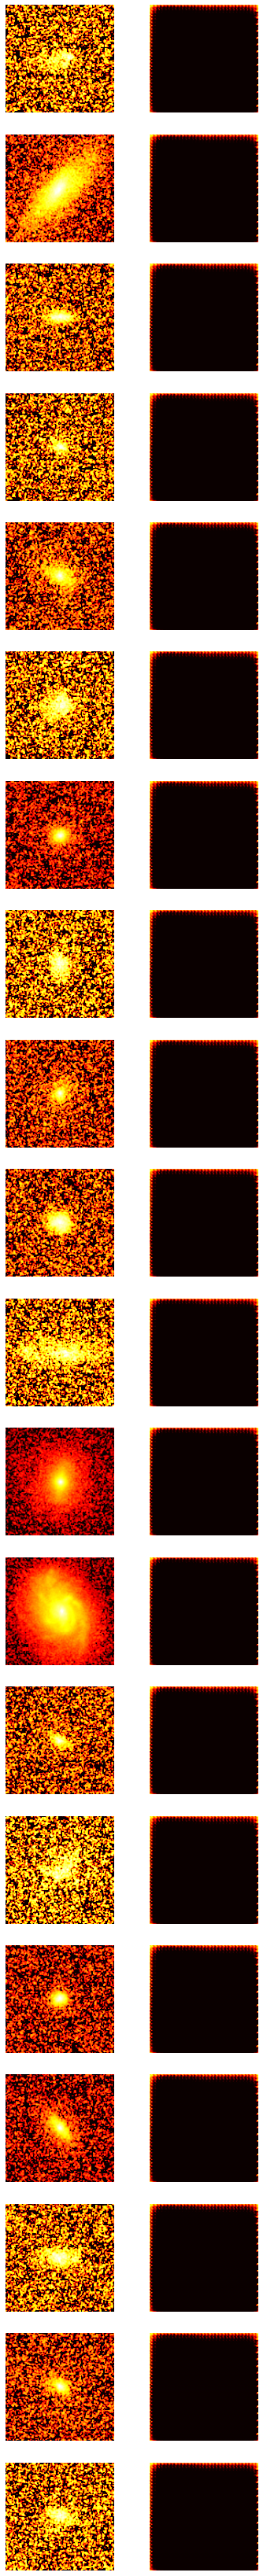

In [163]:
images = 20
fig, axs = plt.subplots(images, 2, figsize=(6, 3 * images))
for i in range(images):
    im = axs[i, 0].imshow(X[i, ..., 0], cmap="hot", norm=ImageNormalize(stretch=LogStretch()))
    axs[i, 0].axis("off")
#     divider = make_axes_locatable(axs[i, 0])
#     cax = divider.append_axes('right', size='5%', pad=0.05)
#     fig.colorbar(im, cax=cax, orientation='vertical')
    
    im = axs[i, 1].imshow(x_pred[i, ..., 0], cmap="hot", norm=ImageNormalize(stretch=LogStretch()))
    axs[i, 1].axis("off")
#     divider = make_axes_locatable(axs[i, 1])
#     cax = divider.append_axes('right', size='5%', pad=0.05)
#     fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
self = AE
image = X
psf = PSF
ps = PS
skip_strength = 1
l2_bottleneck = 1.
apodization_alpha = 0.4
apodization_factor = 0.
tv_factor = 1e-3
input_shape = image.shape
psf_image = tf.signal.irfft2d(tf.cast(psf[..., 0], tf.complex64))[..., tf.newaxis]
# Roll the image to undo the fftshift, assuming x1 zero padding and x2 subsampling
psf_image = tf.roll(psf_image, shift=[input_shape[1], input_shape[2]], axis=[1, 2])
psf_image = tf.image.resize_with_crop_or_pad(psf_image, input_shape[1], input_shape[2])
x = tf.concat([image, psf_image], axis=-1)  # stack psf information in input

z, skips = self.encoder.call_with_skip_connections(x)
x_pred, bottleneck_l2_cost = self.decoder.call_with_skip_connections(z, skips, skip_strength, l2_bottleneck)

# apply optional apodization loss
if apodization_alpha > 0 and apodization_factor > 0:
    nx = x_pred.shape[1]
    alpha = 2 * apodization_alpha / nx
    w = tukey(nx, alpha)
    w = np.outer(w, w).reshape((1, nx, nx, 1)).astype('float32')
    # Penalize non zero pixels near the border
    apo_loss = apodization_factor * tf.reduce_mean(tf.reduce_sum(((1. - w) * x_pred) ** 2, axis=[1, 2, 3]))
else:
    w = 1.0
    apo_loss = 0.

x_pred = x_pred * w

# apply optional tv loss (penalize high frequencies features in the output)
if tv_factor > 0:
    tv_loss = tv_factor * tf.image.total_variation(x_pred)
    # Smoothed Isotropic TV:
    # im_dx, im_dy = tf.image.image_gradients(x_pred)
    # tv_loss = tv_factor * tf.reduce_sum(tf.sqrt(im_dx**2 + im_dy**2 + 1e-6), axis=[1,2,3])
else:
    tv_loss = 0.

# x_pred = convolve(x_pred, tf.cast(psf[..., 0], tf.complex64), zero_padding_factor=1) # we already padded psf with noise in data preprocessing

# compute loss in Fourier space (where covariance matrix is diagonal)
x_true = tf.signal.rfft2d(image[..., 0])
# x_pred = tf.signal.rfft2d(x_pred[..., 0])

chi_squared = 0.5 * tf.reduce_mean(tf.abs((x_true - x_pred))**2 / tf.exp(ps)[..., 0] / (2 * pi) ** 2, axis=[1, 2])

In [115]:
# x_pred = convolve(tf.constant(image) + 0 * tf.random.normal(shape=image.shape, stddev=1), tf.cast(psf[..., 0], tf.complex64), zero_padding_factor=1)
x_pred = image + 1e-4 * tf.random.normal(shape=image.shape, stddev=1)
x_pred = tf.signal.rfft2d(x_pred[..., 0])
x_true = tf.signal.rfft2d(image[..., 0])
chi_squared = 0.5 * tf.reduce_mean(tf.abs((x_true - x_pred))**2 / tf.exp(ps)[..., 0] / (2 * pi) ** 2, axis=[1, 2])
chi_squared

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.56764996, 0.81163037, 0.6576287 , 0.7722295 , 0.79003793,
       0.33891782, 0.35092935, 0.92285913, 0.77311903, 0.3331575 ,
       0.83535826, 0.49920025, 0.6783547 , 0.71370757, 0.7498417 ,
       0.74272907, 0.29322428, 0.78786665, 0.7683635 , 0.6943546 ],
      dtype=float32)>